<a href="https://colab.research.google.com/github/keesree/2400Project0/blob/main/coloring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install opencv-python tqdm

import os, cv2, math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from IPython.display import display
from PIL import Image

# CPU only to keep things simple
device = "cpu"
torch.manual_seed(42)
os.makedirs("samples", exist_ok=True)

def denorm(x):  # [-1,1] -> [0,1]
    return (x.clamp(-1,1) + 1) / 2


In [ ]:
class CIFAR10Edges(Dataset):
    def __init__(self, root="./data", train=True):
      # ready to use dataset that contains 10 object image classes(airplace, cat, etc.) provided by torch.utils.data.dataset
        self.base = datasets.CIFAR10(
            root=root, train=train, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # targets in [-1,1]
            ])
        )

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]                    # tensor in [-1,1], [3,32,32]
        # build edges from a uint8 RGB copy
        img_np = ((img.permute(1,2,0).numpy() + 1.0) * 0.5 * 255.0).astype(np.uint8)
        #turning color into grayscale
        gray   = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        edges  = cv2.Canny(gray, 100, 200).astype(np.float32) / 255.0   # [H,W] in [0,1]
        edges  = torch.from_numpy(edges).unsqueeze(0)                   # [1,32,32]
        edges  = edges * 2 - 1                                          # -> [-1,1]
        return edges, img

# loaders (small batch + single worker = CPU friendly)
batch_size = 32
train_ds = CIFAR10Edges(train=True)
val_ds   = CIFAR10Edges(train=False)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

# quick peek
# edge images, shape [32, 1, 32, 32]
# color CIFAR-10 images, shape [32, 3, 32, 32]
cond, target = next(iter(train_loader))
print("cond (edges):", cond.shape, cond.min().item(), cond.max().item())
print("target (color):", target.shape, target.min().item(), target.max().item())


100%|██████████| 170M/170M [00:05<00:00, 33.5MB/s]


cond (edges): torch.Size([32, 1, 32, 32]) -1.0 1.0
target (color): torch.Size([32, 3, 32, 32]) -1.0 1.0


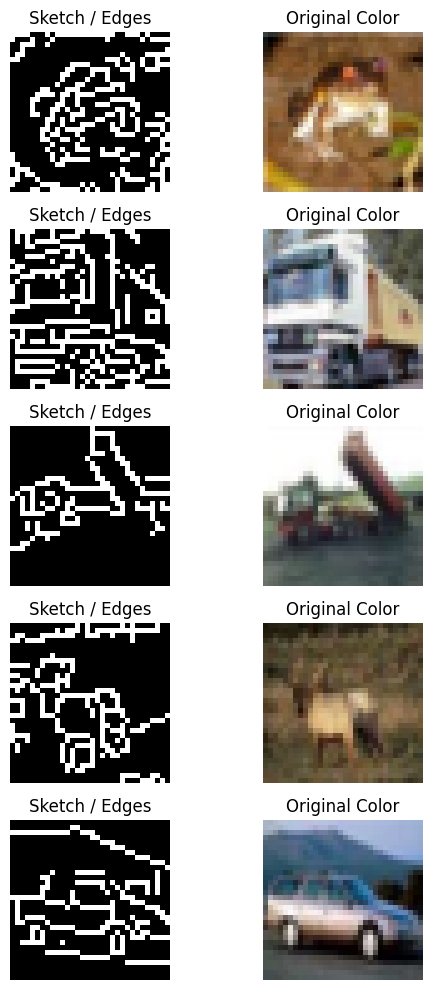

In [ ]:
import matplotlib.pyplot as plt

# Grab a few examples from the dataset
examples = [train_ds[i] for i in range(5)]  # first 5 samples
fig, axes = plt.subplots(len(examples), 2, figsize=(6, 10))

for i, (edge, color) in enumerate(examples):
    edge_img = (edge.squeeze().numpy() + 1) / 2  # [-1,1] -> [0,1]
    color_img = ((color.permute(1,2,0).numpy() + 1) / 2)
    axes[i, 0].imshow(edge_img, cmap='gray')
    axes[i, 0].set_title("Sketch / Edges")
    axes[i, 1].imshow(color_img)
    axes[i, 1].set_title("Original Color")
    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class UNetGen(nn.Module):
    # very small U-Net to keep CPU training reasonable
    def __init__(self, in_ch=1, out_ch=3, base=32):
        super().__init__()
        # downsampling layers, shrink image while learning features
        d1 = nn.Sequential(nn.Conv2d(in_ch, base, 4,2,1), nn.LeakyReLU(0.2,True))                  # 16x16
        d2 = nn.Sequential(nn.Conv2d(base, base*2,4,2,1), nn.BatchNorm2d(base*2), nn.LeakyReLU(0.2,True)) # 8x8
        d3 = nn.Sequential(nn.Conv2d(base*2, base*4,4,2,1), nn.BatchNorm2d(base*4), nn.LeakyReLU(0.2,True)) # 4x4
        self.down = nn.ModuleList([d1,d2,d3])
        #upsampling, builds image again
        self.up3 = nn.Sequential(nn.ConvTranspose2d(base*4, base*2,4,2,1), nn.BatchNorm2d(base*2), nn.ReLU(True))   # 8x8
        self.up2 = nn.Sequential(nn.ConvTranspose2d(base*2*2, base,4,2,1),   nn.BatchNorm2d(base),   nn.ReLU(True)) # 16x16
        self.up1 = nn.Sequential(nn.ConvTranspose2d(base*2, out_ch,4,2,1), nn.Tanh())                               # 32x32
    def forward(self, x):
        s = [] # used to remember details from original sketch
        for d in self.down:
            x = d(x); s.append(x)
        x = self.up3(x)
        x = torch.cat([x, s[-2]], dim=1)
        x = self.up2(x)
        x = torch.cat([x, s[-3]], dim=1)
        x = self.up1(x)
        return x

class PatchDiscrim(nn.Module):
    # input is concatenated [cond(1ch) | img(3ch)] -> 4 channels
    def __init__(self, in_ch=4, base=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, base, 4,2,1), nn.LeakyReLU(0.2,True),                # 16x16
            nn.Conv2d(base, base*2,4,2,1), nn.BatchNorm2d(base*2), nn.LeakyReLU(0.2,True),  # 8x8
            nn.Conv2d(base*2, base*4,4,2,1), nn.BatchNorm2d(base*4), nn.LeakyReLU(0.2,True), # 4x4
            nn.Conv2d(base*4, 1, 3,1,1)  # patch logits
        )
    def forward(self, x): return self.net(x)

G, D = UNetGen().to(device), PatchDiscrim().to(device)
sum(p.numel() for p in G.parameters()), sum(p.numel() for p in D.parameters())


(364931, 167649)

In [ ]:
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
lambda_l1 = 50.0  # smaller for faster CPU convergence

def train_one_epoch(epoch):
    G.train(); D.train()
    running_d, running_g = 0.0, 0.0
    for cond, target in train_loader:
        cond, target = cond.to(device), target.to(device) # looping through edge(cond) and color(target) images

        # --- Train D ---
        with torch.no_grad():
            fake = G(cond)
        real_pair = torch.cat([cond, target], 1)
        fake_pair = torch.cat([cond, fake],   1)
        pred_real = D(real_pair)
        pred_fake = D(fake_pair)
        d_loss = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real)) + \
                 F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        opt_D.zero_grad(); d_loss.backward(); opt_D.step()

        # --- Train G ---
        fake = G(cond)
        fake_pair = torch.cat([cond, fake], 1)
        pred_fake = D(fake_pair)
        g_adv = F.binary_cross_entropy_with_logits(pred_fake, torch.ones_like(pred_fake))
        g_l1  = torch.mean(torch.abs(fake - target))
        g_loss = g_adv + lambda_l1 * g_l1
        opt_G.zero_grad(); g_loss.backward(); opt_G.step()

        running_d += d_loss.item()
        running_g += g_loss.item()

    print(f"Epoch {epoch}: D {running_d/len(train_loader):.3f} | G {running_g/len(train_loader):.3f}")

def save_sample(epoch):
    G.eval()
    with torch.no_grad():
        cond_b, tgt_b = next(iter(val_loader))
        cond_b, tgt_b = cond_b.to(device)[:8], tgt_b.to(device)[:8]
        fake_b = G(cond_b)
        grid = torch.cat([
            denorm(cond_b).expand(-1,3,-1,-1),  # show edges as 3ch
            denorm(fake_b),
            denorm(tgt_b)
        ], dim=0)
        save_image(grid, f"samples/epoch_{epoch:03d}.png", nrow=8)
        print(f"Saved samples/epoch_{epoch:03d}.png")

for ep in range(1, 4):  # do 3 quick epochs first; bump later if you like
    train_one_epoch(ep)
    save_sample(ep)


Epoch 1: D 0.682 | G 26.747
Saved samples/epoch_001.png
Epoch 2: D 0.636 | G 27.375
Saved samples/epoch_002.png
Epoch 3: D 0.590 | G 27.263
Saved samples/epoch_003.png


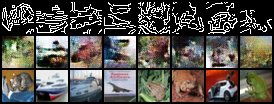

Top: condition (edges) | Middle: generated | Bottom: target


In [ ]:
latest = sorted(os.listdir("samples"))[-1]
display(Image.open(os.path.join("samples", latest)))
print("Top: condition (edges) | Middle: generated | Bottom: target")


In [ ]:
# Run this if you want to keep data/samples for later sessions
from google.colab import drive
drive.mount('/content/drive')

# Example: copy samples to Drive
!mkdir -p "/content/drive/MyDrive/cgan_edges_cifar/samples"
!cp -r samples/* "/content/drive/MyDrive/cgan_edges_cifar/samples/"
print("Backed up to Drive ✅")
